# Introduction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id="section-one"></a>
# Import packages and upload datasets

In [2]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=42ffac5bf71311379e71a01dccc9303e979172008af9b65a490a48c86acd417e
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [3]:
import os
import numpy as np
import ta
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
nltk.download('vader_lexicon')
import shutil

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [4]:
all_tweets = pd.read_csv('/content/drive/MyDrive/ST456/Project/stock_tweets.csv')
all_stocks = pd.read_csv('/content/drive/MyDrive/ST456/Project/stock_yfinance_data.csv')

# Data Cleaning Functions

In [5]:
def clean_data(tweet_data, stock_data, stock_name):
  stock_name = stock_name
  df = tweet_data[tweet_data['Stock Name'] == stock_name]

  sent_df = df.copy()
  sent_df["sentiment_score"] = ''
  sent_df["Negative"] = ''
  sent_df["Neutral"] = ''
  sent_df["Positive"] = ''

  %time
  sentiment_analyzer = SentimentIntensityAnalyzer()
  for indx, row in sent_df.T.iteritems():
      try:
          sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
          sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
          sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
          sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
          sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
          sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
      except TypeError:
          print (sent_df.loc[indx, 'Tweet'])
          print (indx)
          break

  sent_df['Date'] = pd.to_datetime(sent_df['Date'])
  sent_df['Date'] = sent_df['Date'].dt.date
  sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Company Name'])
  twitter_df = sent_df.groupby(['Date']).mean()

  twitter_df = twitter_df.reset_index()

  all_stocks['Date'] = pd.to_datetime(all_stocks['Date'])
  all_stocks['Date'] = all_stocks['Date'].dt.date

  stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
  final_df = stock_df.merge(twitter_df, on = ['Date'], how = 'left')
  final_df = final_df.loc[:,['Date', 'Stock Name', 'sentiment_score', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
  final_df.reset_index(inplace = True, drop = True)

  cols = 0
  rows = 0 

  fig, ax = plt.subplots(1, 1, figsize = (20,8), tight_layout = True)

  for tic in list(final_df['Stock Name'].unique()):
      ax.plot(final_df.loc[final_df['Stock Name'] == tic, 'Date'] ,final_df.loc[final_df['Stock Name'] == tic,'Close'], color='#008B8B')
      ax.set(xlabel='Date', ylabel='USD', title=f'{tic} Stock Price')
      ax.xaxis.set_major_formatter(DateFormatter('%Y'))

  plt.show()

  def get_tech_ind(data):

    # Adding Simple Moving Average
    data['MA7'] = ta.trend.sma_indicator(close = data.iloc[:,6], window = 7)
    data['MA20'] = ta.trend.sma_indicator(close = data.iloc[:,6], window = 20)
    
    # Adding MACD
    data['MACD'] = ta.trend.macd(close = data.iloc[:,6])

    # Adding Rate of Change
    data['ROC'] = ta.momentum.roc(close = data.iloc[:,6], window = 12)

    # Adding Exponential Moving Average
    data['EMA'] = ta.trend.ema_indicator(close = data.iloc[:,6])

    # Adding Bollinger Bands
    data['Bollinger_Bands'] = ta.volatility.BollingerBands(close = data.iloc[:,6]).bollinger_mavg()

    # Adding LogMomentum
    data['Log_Momentum'] = np.log(data.iloc[:,6]-1)

    return data

  tech_df = pd.DataFrame()

  df_1 = final_df[final_df['Stock Name'] == stock_name]
  df_2 = get_tech_ind(df_1)
  df_2 = df_2.iloc[25:,].reset_index(drop=True)
  tech_df = pd.concat([tech_df,df_2], axis = 0)

  cols = 0
  rows = 0 

  fig, ax = plt.subplots(1, 1, figsize = (20,8), tight_layout = True);

  for tic in list(tech_df['Stock Name'].unique()):
    
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'MA7'], color='g', linestyle='--', label='Moving Average (7 days)');
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'Close'], color='#6A5ACD', label='Closing Price');
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'MA20'], color='r', linestyle='-.', label='Moving Average (20 days)');
      ax.set(xlabel='Date', ylabel='USD', title=f'{tic} Technical Indicators');
      ax.xaxis.set_major_formatter(DateFormatter('%Y'));
      ax.legend();


  plt.show();

  tech_df = tech_df.drop(['Stock Name'], axis = 1)
  date_col = tech_df['Date']
  tech_df = tech_df.set_index('Date')
  tech_df = tech_df.sort_values('Date')
  tech_df.reset_index(inplace=True,drop=True)

  X = tech_df.drop(['Adj Close'], axis = 1)
  y = pd.DataFrame(tech_df['Adj Close'])

  return X, y, date_col


def data_preprocess(X, y, days, predict):
  X_scaler = MinMaxScaler()
  y_scaler = MinMaxScaler()
  X_scaled_df = X_scaler.fit_transform(X)
  y_scaled_df = y_scaler.fit_transform(y)
  print(X_scaled_df.shape)

  days_to_consider = days
  n_features = X_scaled_df.shape[1]
  days_to_predict = predict

  def x_y_predictions(x_data, y_data):
    X_data = []
    Y_data = []
    YC_data = []

    for i in range(0,len(x_data),1):
      X = x_data[i: i + days_to_consider][:,:]
      y = y_data[i + days_to_consider : i + days_to_consider + days_to_predict][:,0]
      yc = y_data[i: i + days_to_consider][:,:]
      if len(X) == days_to_consider and len(y) == days_to_predict:
        X_data.append(X)
        Y_data.append(y)
        YC_data.append(yc)

    return np.array(X_data), np.array(Y_data), np.array(YC_data)

  X, y, yc = x_y_predictions(X_scaled_df, y_scaled_df)

  def split_train_test(data):
    train_size = round(len(data) * 0.85)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

  X_train, X_test = split_train_test(X)
  y_train, y_test = split_train_test(y)
  yc_train, yc_test = split_train_test(yc)
  print('X_train shape', X_train.shape)
  print('y_train shape', y_train.shape)
  print('yc_train shape', yc_train.shape)
  print('X_test shape', X_test.shape)
  print('y_test shape', y_test.shape)
  print('yc_test shape', yc_test.shape)

  input_dim = X_train.shape[1] 
  feature_size = X_train.shape[2] 
  output_dim = y_train.shape[1]

  print('Input dimension', input_dim)
  print('Feature dimension', feature_size)
  print('Output dimension', output_dim)

  return X_train, y_train, yc_train, X_test, y_test, y_scaler

<a id="section-four"></a>
# Build GAN model

Generator model

In [30]:
def make_generator_model(input_dim, feature_size, output_dim):
    model = tf.keras.Sequential([LSTM(units = 128, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 64, return_sequences = True, recurrent_dropout = 0.3),
                               #LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               #LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 32, recurrent_dropout = 0.3),
                               #Dense(64),
                               #Dense(32),
                               #Dense(8),
                               Dense(output_dim)])
    return model

Discriminator model

In [31]:
def make_discriminator_model(input_dim, output_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(128, input_shape=(input_dim + output_dim, 1), kernel_size=7, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(8, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    #cnn_net.add(Dense(64, use_bias=False))
    #cnn_net.add(LeakyReLU())
    #cnn_net.add(Dense(32, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [32]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [33]:
def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [34]:
class GAN_model:
  def __init__(self, generator, discriminator, parameters, discriminator_loss, generator_loss):
      self.generator = generator
      self.discriminator = discriminator
      self.batch_size = parameters[0]
      self.epochs = parameters[1]
      self.discriminator_loss = discriminator_loss
      self.generator_loss = generator_loss
      #self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate = parameters[0], beta_1=0.5)
      self.generator_optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate = parameters[0], beta_1=0.5, beta_2 = 0.999)
      #self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = parameters[0], beta_1=0.5)
      self.discriminator_optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate = parameters[0], beta_1=0.5, beta_2 = 0.999)
      self.discriminator.compile(loss=self.discriminator_loss, optimizer = self.discriminator_optimizer)

  def return_generator(self):
      return self.generator

  @tf.function
  def train_step(self, real_x, real_y, yc):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            print(generated_data.shape)
            generated_data_reshaped = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            print(generated_data_reshaped.shape)
            d_fake_input = tf.concat([tf.cast(generated_data_reshaped, tf.float64), yc], axis=1)
            print(d_fake_input.shape)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)
            print(d_real_input.shape)

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(
          zip(gradients_of_discriminator, self.discriminator.trainable_variables))
      return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

In [35]:
def train(real_x, real_y, yc, parameters, gan_model):
    train_history = {}
    train_history['D_losses'] = []
    train_history['G_losses'] = []
    train_history['per_epoch_times'] = []

    rmse_prev = 10
    epochs = parameters[1]
    for epoch in range(epochs):
      real_price, fake_price, loss = gan_model.train_step(real_x, real_y, yc)

      generator_losses = []
      discriminator_losses = []

      Real_price = []
      Predicted_price = []

      discriminator_losses.append(loss['d_loss'].numpy())
      generator_losses.append(loss['g_loss'].numpy())

      Predicted_price.append(fake_price.numpy())
      Real_price.append(real_price.numpy())

      rmse = np.sqrt(mean_squared_error(real_price, fake_price))
      #print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy(), 'RMSE', rmse)

      if epoch >= 0.95 * epochs:
        tf.keras.models.save_model(gan_model.return_generator(), f'./models_gan/generator_V_%d.h5' % epoch)

      if epoch == epochs - 1:
        tf.keras.models.save_model(gan_model.return_generator(), f'./models_gan/generator_V_%d.h5' % epoch)

      train_history['D_losses'].append(discriminator_losses)
      train_history['G_losses'].append(generator_losses)

    predicted_price = np.array(Predicted_price)
    predicted_price = predicted_price.reshape(predicted_price.shape[1], predicted_price.shape[2])
    real_price = np.array(Real_price)
    real_price = real_price.reshape(real_price.shape[1], real_price.shape[2])

    plt.plot(train_history['D_losses'], label='D_loss')
    plt.plot(train_history['G_losses'], label='G_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return predicted_price, real_price, np.sqrt(mean_squared_error(real_price, predicted_price))








# Start

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


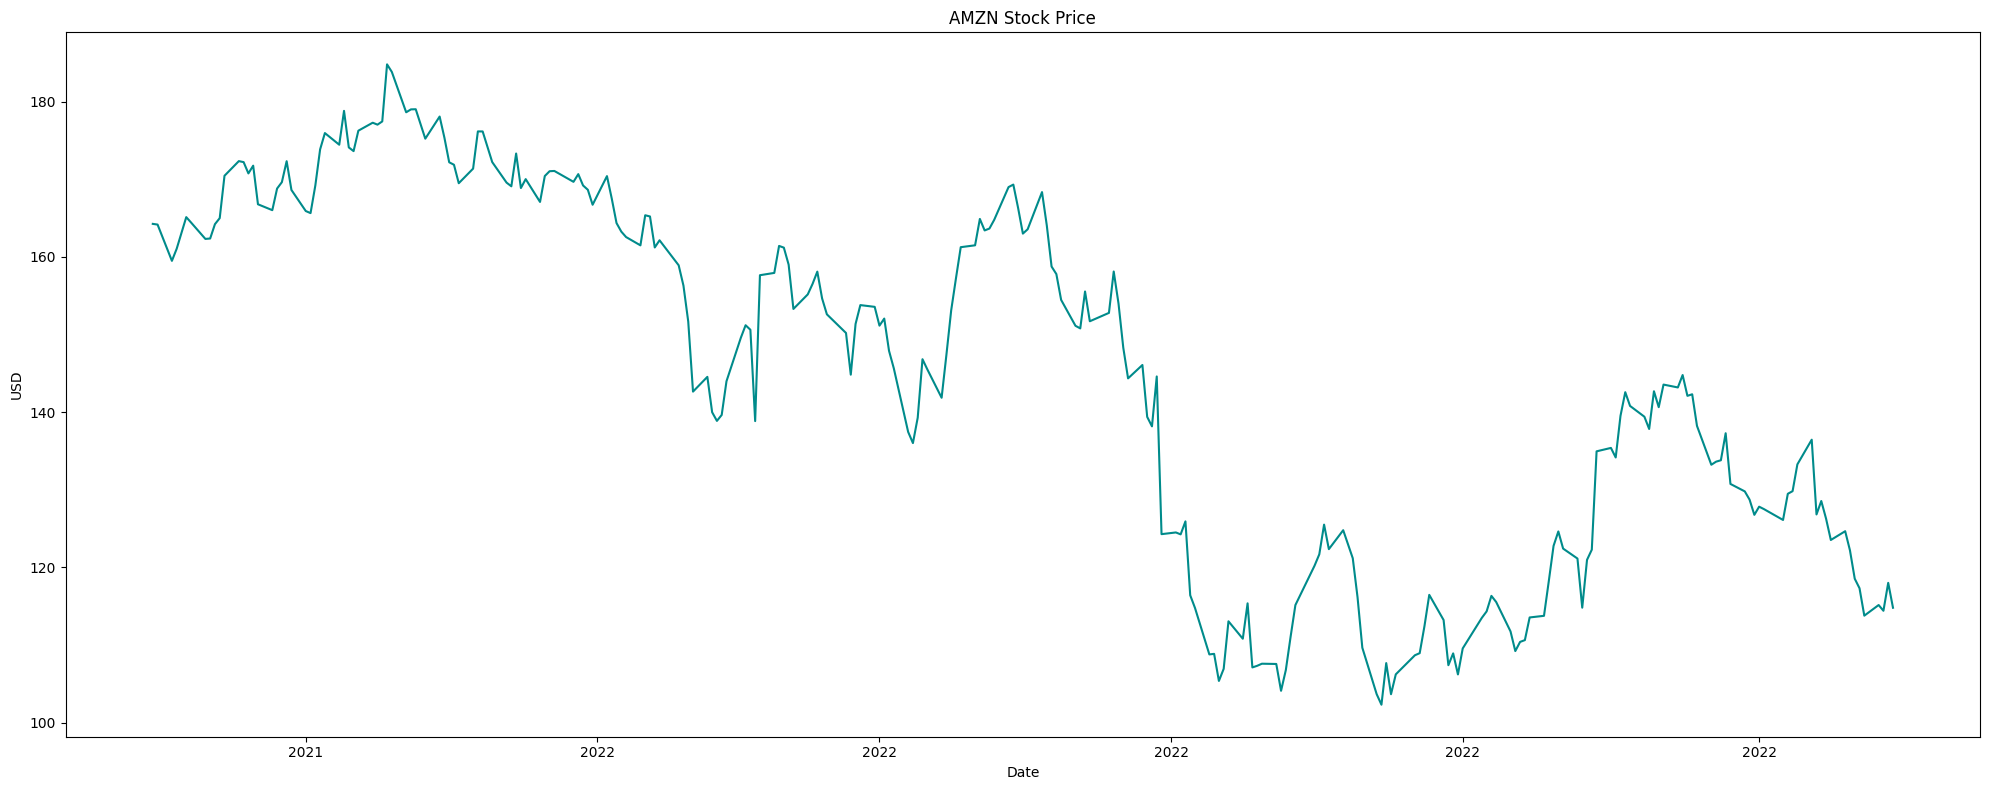

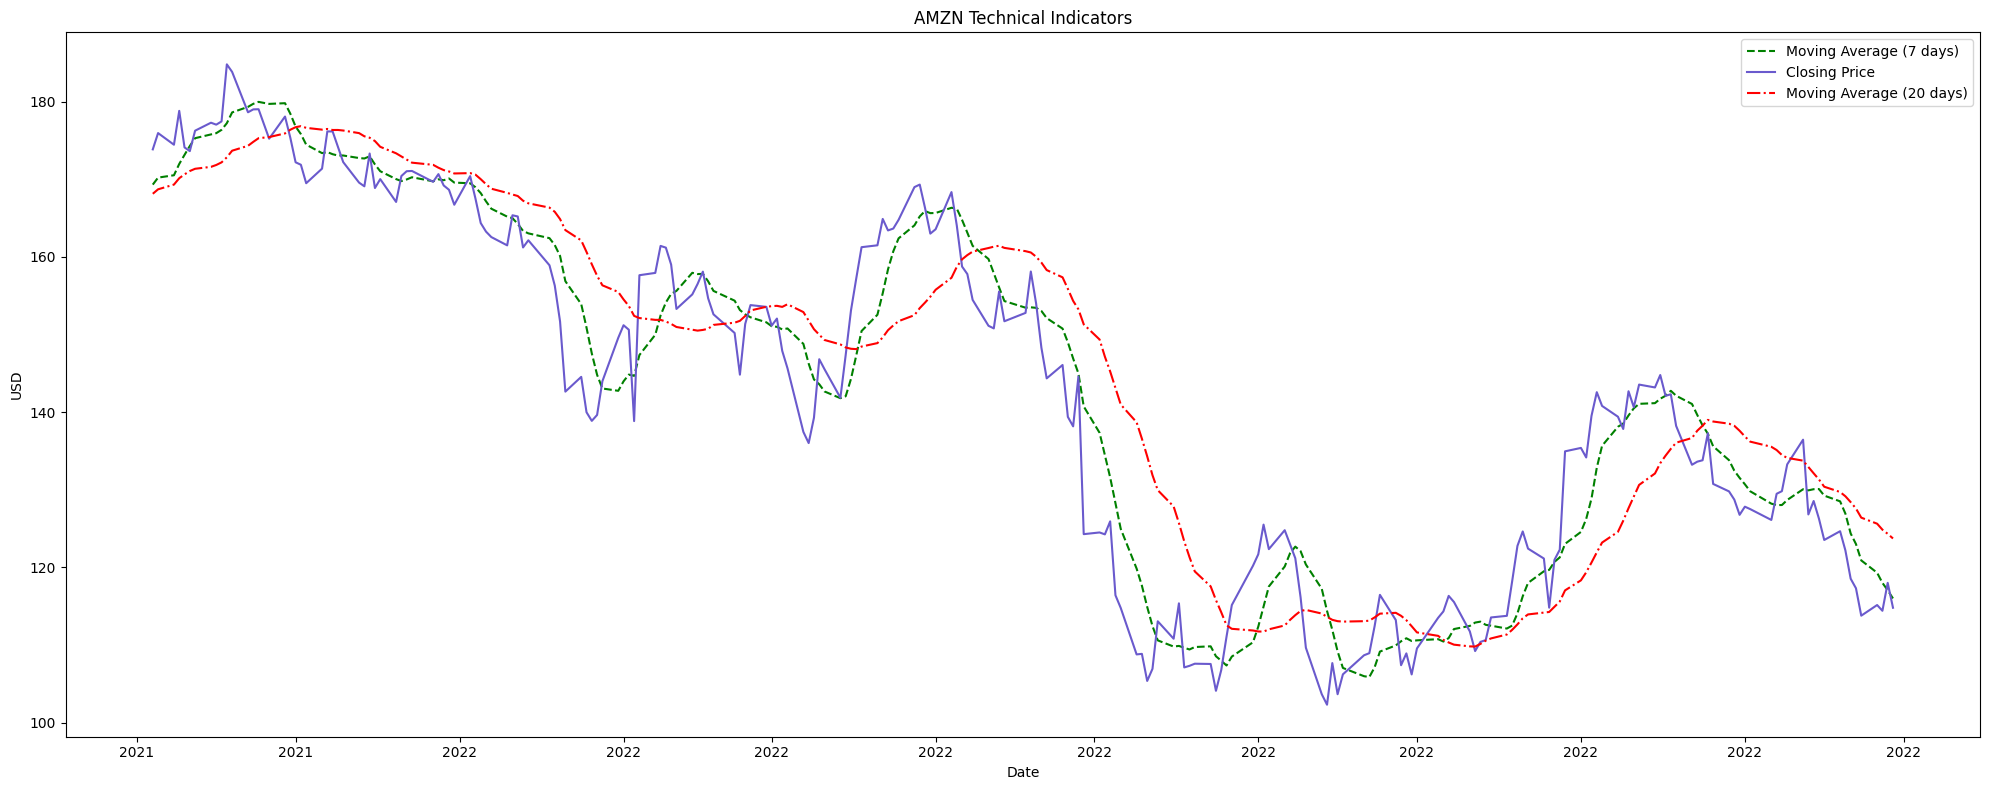

In [36]:
stock_name = 'AMZN'
X, y, date = clean_data(all_tweets, all_stocks, stock_name)

# Experimentation with different parameters

In [37]:
hyper_parameters = {'learning_rate' : [1e-3, 1e-4, 1e-5],
                    'days to consider' : [3,4,5,7],
                    'days to predict' : [2,3]}
print(hyper_parameters)

{'learning_rate': [0.001, 0.0001, 1e-05], 'days to consider': [3, 4, 5, 7], 'days to predict': [2, 3]}


##Experimentation with different number of days to consider

(227, 13)
X_train shape (190, 3, 13)
y_train shape (190, 1)
yc_train shape (190, 3, 1)
X_test shape (34, 3, 13)
y_test shape (34, 1)
yc_test shape (34, 3, 1)
Input dimension 3
Feature dimension 13
Output dimension 1
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 3, 128)            72704     
                                                                 
 lstm_67 (LSTM)              (None, 3, 64)             49408     
                                                                 
 lstm_68 (LSTM)              (None, 32)                12416     
                                                                 
 dense_44 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

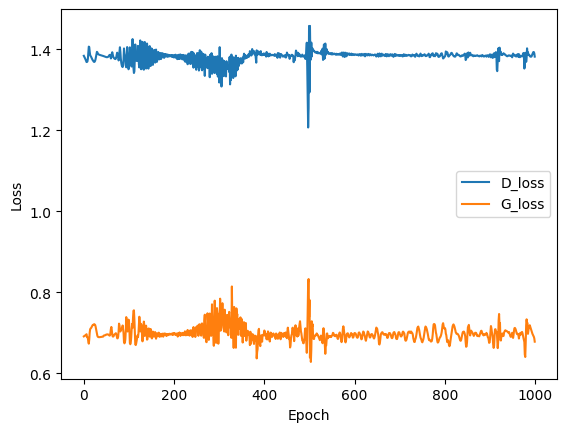

Training RMSE 6.8412009159665


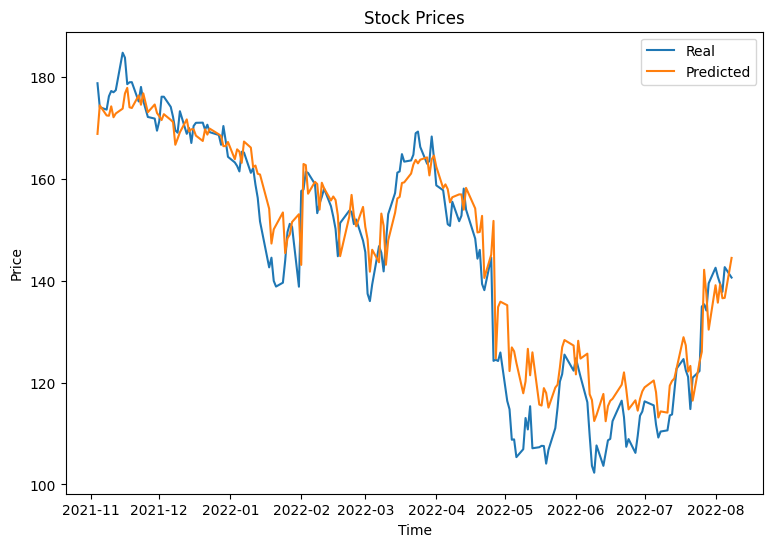

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_70 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_71 (LSTM)              (None, 32)                12416     
                                                                 
 dense_46 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

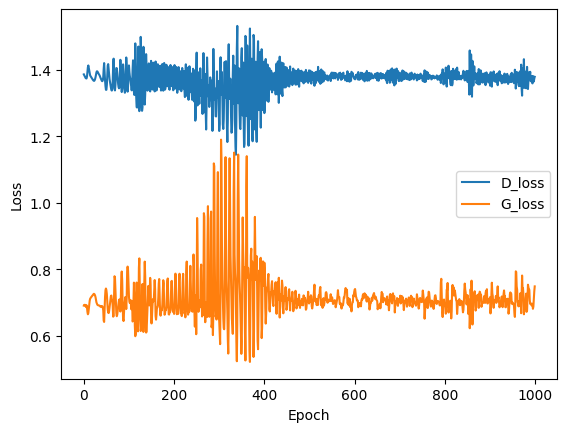

Training RMSE 6.79892806189142


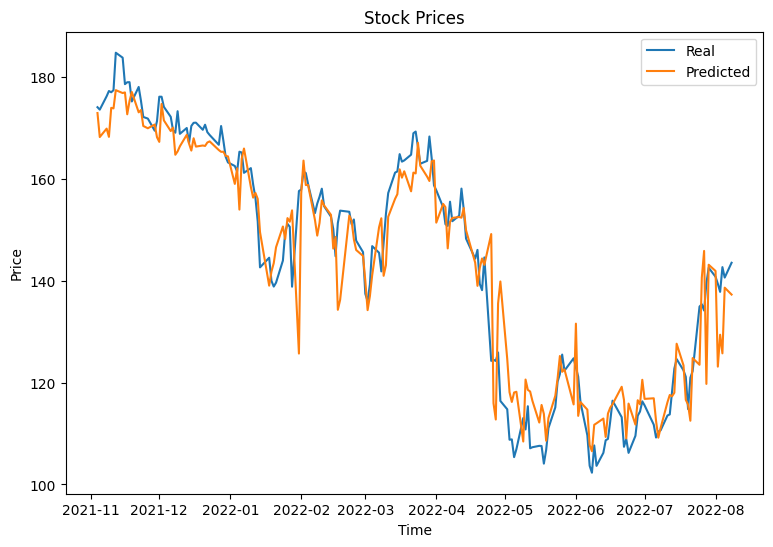

(227, 13)
X_train shape (189, 5, 13)
y_train shape (189, 1)
yc_train shape (189, 5, 1)
X_test shape (33, 5, 13)
y_test shape (33, 1)
yc_test shape (33, 5, 1)
Input dimension 5
Feature dimension 13
Output dimension 1
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 5, 128)            72704     
                                                                 
 lstm_73 (LSTM)              (None, 5, 64)             49408     
                                                                 
 lstm_74 (LSTM)              (None, 32)                12416     
                                                                 
 dense_48 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

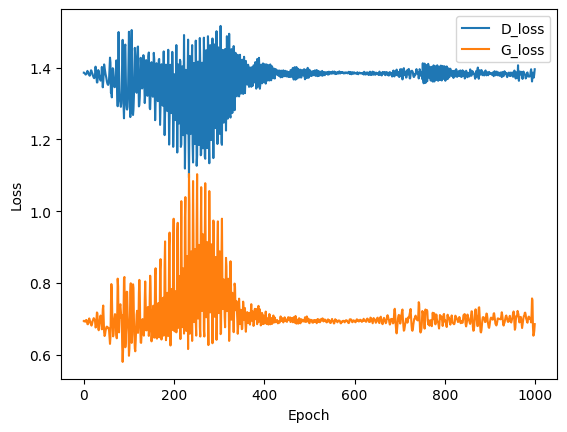

Training RMSE 5.7943005863900865


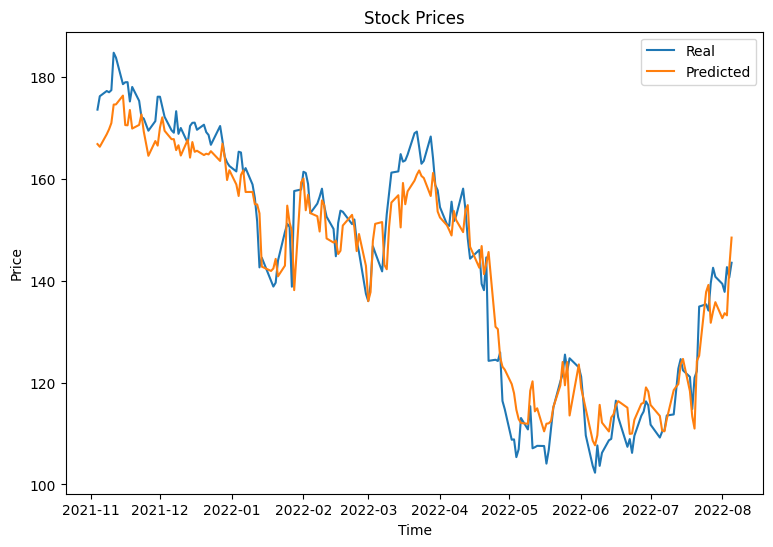

(227, 13)
X_train shape (187, 7, 13)
y_train shape (187, 1)
yc_train shape (187, 7, 1)
X_test shape (33, 7, 13)
y_test shape (33, 1)
yc_test shape (33, 7, 1)
Input dimension 7
Feature dimension 13
Output dimension 1
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 7, 128)            72704     
                                                                 
 lstm_76 (LSTM)              (None, 7, 64)             49408     
                                                                 
 lstm_77 (LSTM)              (None, 32)                12416     
                                                                 
 dense_50 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

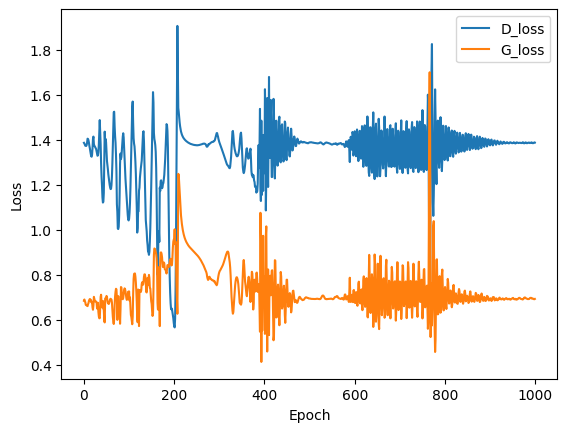

Training RMSE 7.160691339788941


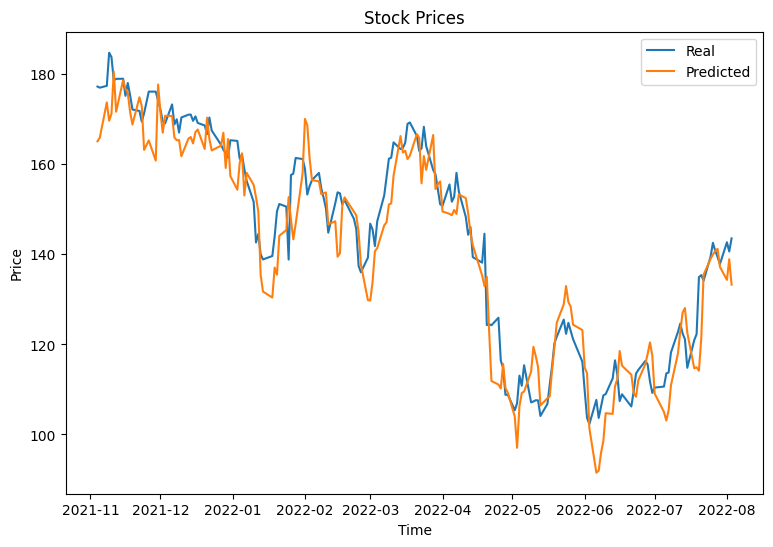

In [44]:
days_to_predict = 1
for days in hyper_parameters['days to consider']:
  parameters = [1e-3, 1000]
  X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days, days_to_predict)

  gen_model = make_generator_model(days, X_train.shape[2], days_to_predict)
  print(gen_model.summary())

  disc_model = make_discriminator_model(days_to_predict, days)
  print(disc_model.summary())

  dir_path = '/content/models_gan'

  if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
  else:
    print(f"Directory '{dir_path}' does not exist.")

  gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
  Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)  

  rescaled_Real_price = y_scaler.inverse_transform(Real_price)
  rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)
  Train_RMSE = np.sqrt(mean_squared_error(rescaled_Real_price, rescaled_Predicted_price))
  print('Training RMSE', Train_RMSE)

  fig, ax = plt.subplots(figsize=(9,6))
  # Plot the two arrays as lines on the same plot
  ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
  ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
  # Set the x-axis and y-axis labels
  ax.set_xlabel('Time')
  ax.set_ylabel('Price')
  # Add a title to the plot
  ax.set_title('Stock Prices')
  # Add a legend to the plot
  ax.legend()
  # Show the plot
  plt.show()

## Experimentation with Learning rate

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_28 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

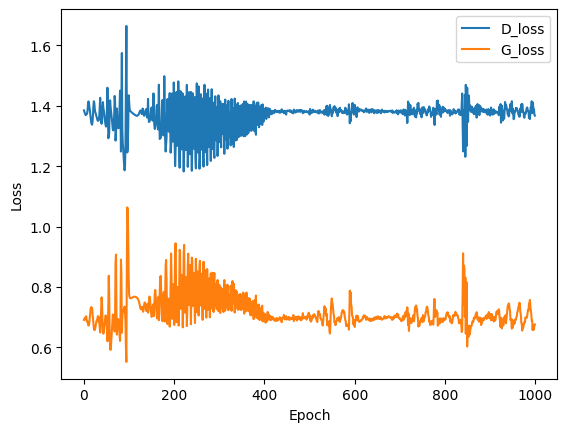

Training RMSE 5.795157901324775


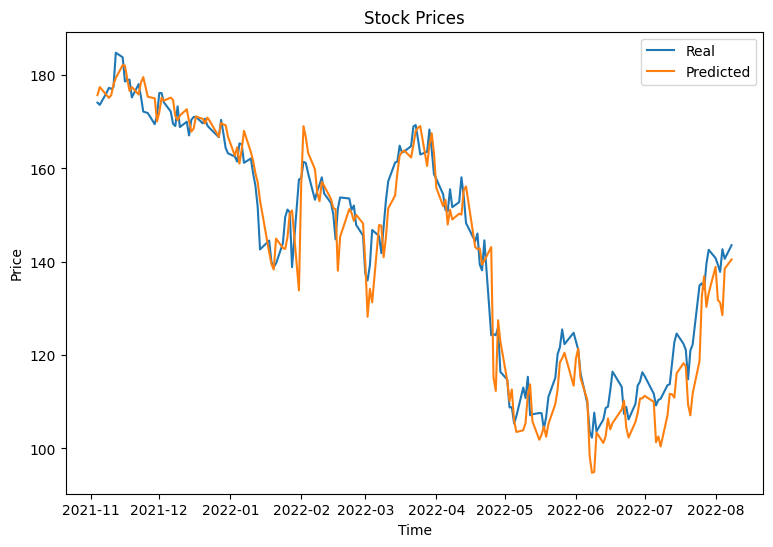

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_31 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_32 (LSTM)              (None, 32)                12416     
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

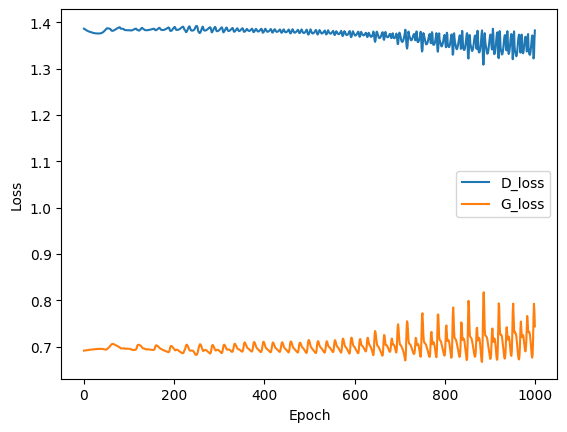

Training RMSE 8.596130317591191


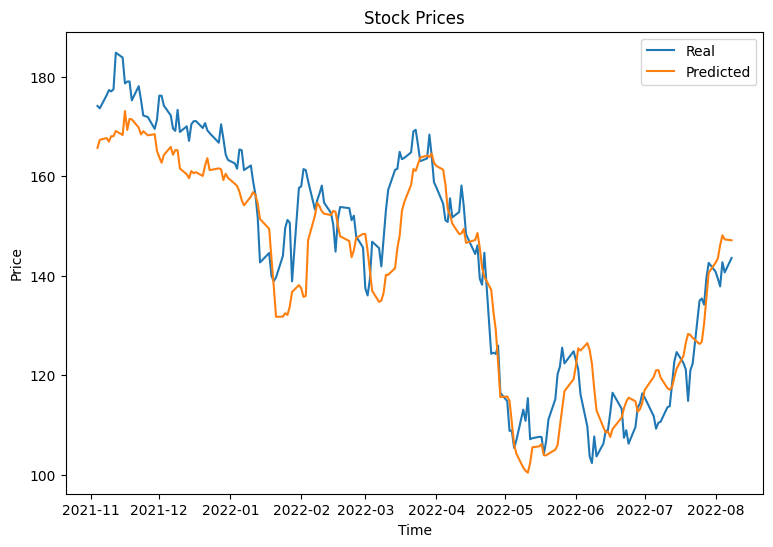

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_34 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_35 (LSTM)              (None, 32)                12416     
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 134,561
Trainable params: 134,561
Non-trainable params: 0
_____________________________

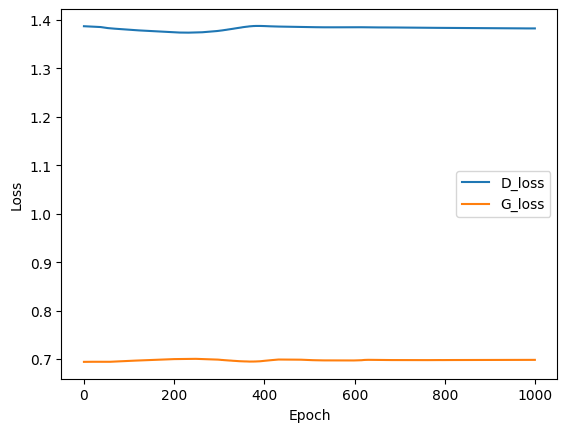

Training RMSE 8.65424917445685


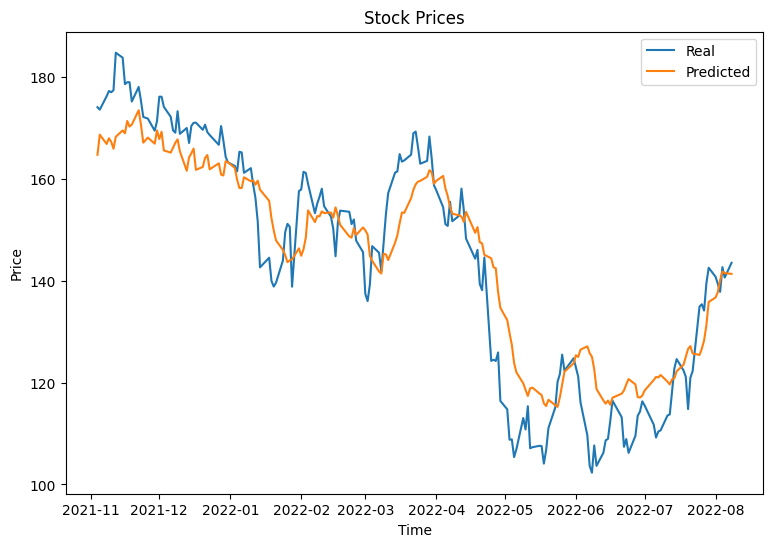

In [39]:
days_to_consider = 4
days_to_predict = 1
for lr in hyper_parameters['learning_rate']:
  parameters = [lr, 1000]
  X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, days_to_predict)

  gen_model = make_generator_model(days_to_consider, X_train.shape[2], days_to_predict)
  print(gen_model.summary())

  disc_model = make_discriminator_model(days_to_predict, days_to_consider)
  print(disc_model.summary())

  dir_path = '/content/models_gan'

  if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
  else:
    print(f"Directory '{dir_path}' does not exist.")

  gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
  Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)  

  rescaled_Real_price = y_scaler.inverse_transform(Real_price)
  rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)
  Train_RMSE = np.sqrt(mean_squared_error(rescaled_Real_price, rescaled_Predicted_price))
  print('Training RMSE', Train_RMSE)

  fig, ax = plt.subplots(figsize=(9,6))
  # Plot the two arrays as lines on the same plot
  ax.plot(date[:X_train.shape[0]], rescaled_Real_price, label='Real')
  ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
  # Set the x-axis and y-axis labels
  ax.set_xlabel('Time')
  ax.set_ylabel('Price')
  # Add a title to the plot
  ax.set_title('Stock Prices')
  # Add a legend to the plot
  ax.legend()
  # Show the plot
  plt.show()

##Experimentation with different number of days to predict

(227, 13)
X_train shape (189, 4, 13)
y_train shape (189, 2)
yc_train shape (189, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 2)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 2
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_49 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_50 (LSTM)              (None, 32)                12416     
                                                                 
 dense_32 (Dense)            (None, 2)                 66        
                                                                 
Total params: 134,594
Trainable params: 134,594
Non-trainable params: 0
_____________________________

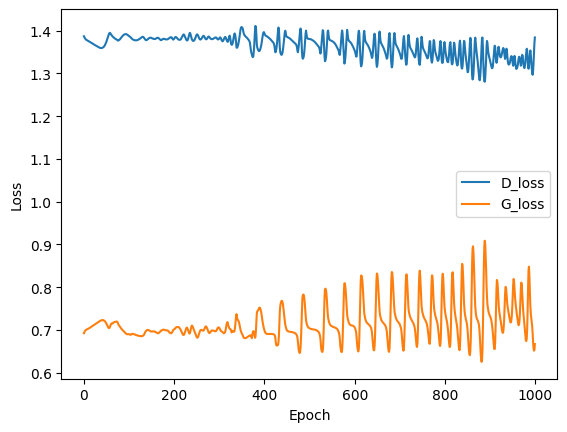

Training RMSE 10.49694293380813


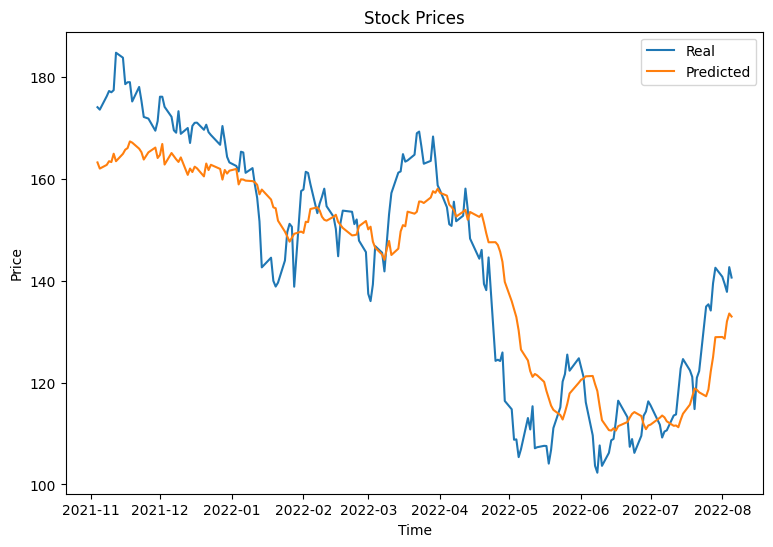

(227, 13)
X_train shape (188, 4, 13)
y_train shape (188, 3)
yc_train shape (188, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 3)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 3
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 4, 128)            72704     
                                                                 
 lstm_52 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_53 (LSTM)              (None, 32)                12416     
                                                                 
 dense_34 (Dense)            (None, 3)                 99        
                                                                 
Total params: 134,627
Trainable params: 134,627
Non-trainable params: 0
_____________________________

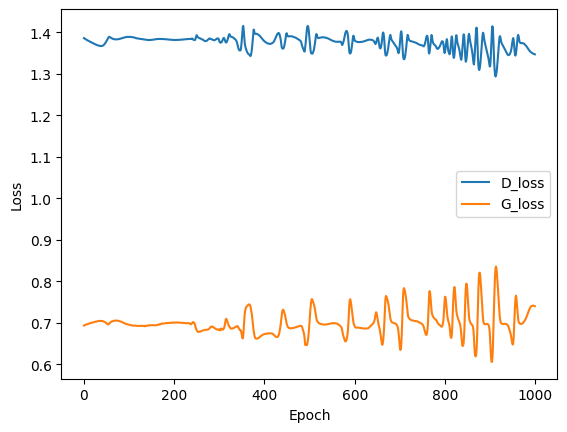

Training RMSE 14.426142223166114


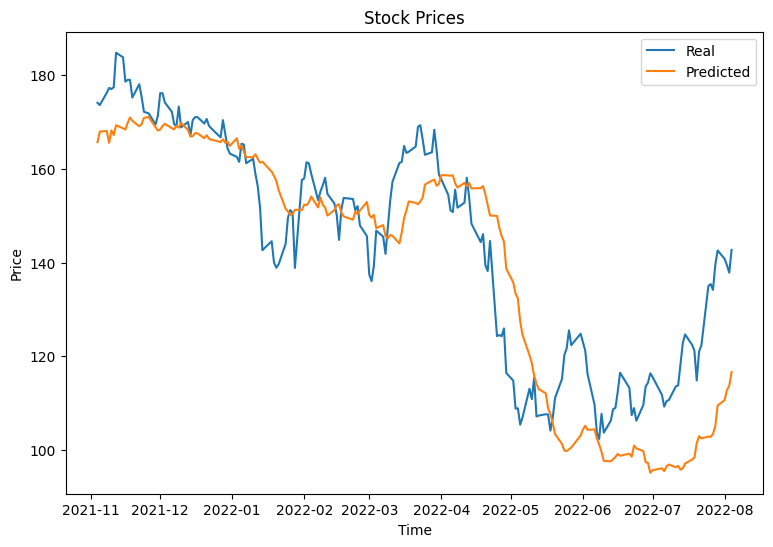

In [42]:
days_to_consider = 4
for predict_days in hyper_parameters['days to predict']:
  parameters = [1e-4, 1000]
  X_train, y_train, yc_train, X_test, y_test, y_scaler = data_preprocess(X, y, days_to_consider, predict_days)

  gen_model = make_generator_model(days_to_consider, X_train.shape[2], predict_days)
  print(gen_model.summary())

  disc_model = make_discriminator_model(predict_days, days_to_consider)
  print(disc_model.summary())

  dir_path = '/content/models_gan'

  if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
  else:
    print(f"Directory '{dir_path}' does not exist.")

  gan = GAN_model(gen_model, disc_model, parameters, discriminator_loss, generator_loss)
  Predicted_price, Real_price, RMSE = train(X_train, y_train, yc_train, parameters, gan)  

  rescaled_Real_price = y_scaler.inverse_transform(Real_price)
  rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)
  Train_RMSE = np.sqrt(mean_squared_error(rescaled_Real_price, rescaled_Predicted_price))
  print('Training RMSE', Train_RMSE)

  rescaled_Predicted_price = np.mean(rescaled_Predicted_price, axis=1)
  fig, ax = plt.subplots(figsize=(9,6))
  # Plot the two arrays as lines on the same plot
  ax.plot(date[:X_train.shape[0]], rescaled_Real_price[:,0], label='Real')
  ax.plot(date[:X_train.shape[0]],rescaled_Predicted_price, label='Predicted')
  # Set the x-axis and y-axis labels
  ax.set_xlabel('Time')
  ax.set_ylabel('Price')
  # Add a title to the plot
  ax.set_title('Stock Prices')
  # Add a legend to the plot
  ax.legend()
  # Show the plot
  plt.show()